# 1. Imports

In [1]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import scipy
import datetime
import wfdb

import wfdb
from scipy.stats import kurtosis
from scipy.signal import butter,filtfilt
import pywt

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score, ConfusionMatrixDisplay

from catboost import CatBoostClassifier, metrics
from xgboost import XGBClassifier

import os

c:\Users\doxda\anaconda3\envs\py39IIM\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 2. Carregando os dados

## 2.1. X

In [2]:
data_all = pd.DataFrame()
# srate 200 Hz is 1s for the signal
seconds = 10
srate = seconds * 200
# All the folder
for sz in ['sz01', 'sz02', 'sz03', 'sz04', 'sz05', 'sz06', 'sz07']:
    # Leitura dos sinais
    patient=("dados" + f"\\{sz}")
    record = wfdb.rdrecord(patient)
    sig=record.p_signal[:,0]
    N=sig.shape[0]
    x=np.arange(N)
    # Carregando os dados para o DataFrame com algumas transformações
    data_sz = pd.DataFrame(x/(200), columns=['Time'])
    data_sz['Pacient'] = sz
    data_sz['TimeComplete'] = data_sz.Time.apply(lambda time: str(datetime.timedelta(seconds=time)))
    data_sz['TimeComplete'] = pd.to_timedelta(data_sz['TimeComplete'])
    data_sz['Signal'] = sig
    # Janelamento
    data_sz['window'] = 'x'
    i = 1
    for time in range(0, len(data_sz.Time), srate):
        data_sz.loc[time:time+srate, 'window'] = i
        i += 1
    
    data_all = pd.concat([data_all, data_sz])



In [3]:
# Plotando o momento de Epilepsia
temp = data_all[data_all['Pacient'] == 'sz01'].iloc[175500:179000]
fig = go.Figure(data=go.Scatter(x=temp.Time, y=temp.Signal))
fig

## 2.2. Y

In [4]:
for sz in ['sz01', 'sz02', 'sz03', 'sz04', 'sz05', 'sz06', 'sz07']:
    print(f'O tempo max de {sz} é {data_all[data_all["Pacient"] == sz].TimeComplete.max()}')

O tempo max de sz01 é 0 days 01:29:59.985000
O tempo max de sz02 é 0 days 03:29:59.985000
O tempo max de sz03 é 0 days 03:45:59.985000
O tempo max de sz04 é 0 days 01:29:59.985000
O tempo max de sz05 é 0 days 01:30:00.025000
O tempo max de sz06 é 0 days 02:59:59.985000
O tempo max de sz07 é 0 days 01:59:59.985000


In [5]:
# Atribuindo os labels
times = pd.read_csv(r"dados\timesAllPacient.csv", sep=';')


In [6]:
times.head()

,patient,two,N-I,N-F,A-I,A-F,I-I,I-F,P-I,P-F
0,sz01,False,0,0,0,00:14:36,00:14:36,00:16:12,00:16:12,01:29:59.985000
1,sz02-1,True,0,00:32:43,00:32:43,01:02:43,01:02:43,01:03:43,01:03:43,02:25:51
2,sz02-2,True,0,0,02:25:51,02:55:51,02:55:51,02:56:16,02:56:16,03:29:59.985000
3,sz03-1,True,0,00:54:34,00:54:34,01:24:34,01:24:34,01:26:22,01:26:22,02:04:27
4,sz03-2,True,0,0,02:04:27,02:34:27,02:34:27,02:36:17,02:36:17,03:45:59.985000


# 3. Preprocessamento

## 3.1. Y

In [7]:
# Atribuindo os labels
columns_time = times.drop(['patient', 'two'], axis=1).columns
for column in list(columns_time):
    times[column] = pd.to_timedelta(times[column])
Change = {'True': True, 'False': False}
times["two"] = times["two"].replace(Change)

## 3.2. X

In [8]:
data_all['TimeComplete'] = pd.to_timedelta(data_all['TimeComplete'])

### 3.2.1. Atribuindo os target aos tempos corretos, sendo:
 - N- normal;
 - A-Pré-ictal (30 segundos antes das convulsões);
- I- Ictal (ocorrência das convulsões, com os tempos identificados aqui);
-  P-Pós-ictal (2 minutos após as convulsões*).

* Como o período pós-ictal varia de acordo com o paciente e com a intensidade das convulsões, a abordagem correta seria a utilização de uma identificação realizada por especialistas, indisponível para todos os indivíduos do banco.

In [9]:
times

,patient,two,N-I,N-F,A-I,A-F,I-I,I-F,P-I,P-F
0,sz01,False,0 days,0 days 00:00:00,0 days 00:00:00,0 days 00:14:36,0 days 00:14:36,0 days 00:16:12,0 days 00:16:12,0 days 01:29:59.985000
1,sz02-1,True,0 days,0 days 00:32:43,0 days 00:32:43,0 days 01:02:43,0 days 01:02:43,0 days 01:03:43,0 days 01:03:43,0 days 02:25:51
2,sz02-2,True,0 days,0 days 00:00:00,0 days 02:25:51,0 days 02:55:51,0 days 02:55:51,0 days 02:56:16,0 days 02:56:16,0 days 03:29:59.985000
3,sz03-1,True,0 days,0 days 00:54:34,0 days 00:54:34,0 days 01:24:34,0 days 01:24:34,0 days 01:26:22,0 days 01:26:22,0 days 02:04:27
4,sz03-2,True,0 days,0 days 00:00:00,0 days 02:04:27,0 days 02:34:27,0 days 02:34:27,0 days 02:36:17,0 days 02:36:17,0 days 03:45:59.985000
5,sz04,False,0 days,0 days 00:00:00,0 days 00:00:00,0 days 00:20:10,0 days 00:20:10,0 days 00:21:55,0 days 00:21:55,0 days 01:29:59.985000
6,sz05,False,0 days,0 days 00:00:00,0 days 00:00:00,0 days 00:24:07,0 days 00:24:07,0 days 00:25:30,0 days 00:25:30,0 days 01:30:00.025000
7,sz06-1,True,0 days,0 days 00:21:25,0 days 00:21:25,0 days 00:51:25,0 days 00:51:25,0 days 00:52:19,0 days 00:52:19,0 days 01:34:45
8,sz06-2,True,0 days,0 days 00:00:00,0 days 01:34:45,0 days 02:04:45,0 days 02:04:45,0 days 02:06:10,0 days 02:06:10,0 days 02:59:59.985000
9,sz07,False,0 days,0 days 00:38:02,0 days 00:38:02,0 days 01:08:02,0 days 01:08:02,0 days 01:09:31,0 days 01:09:31,0 days 01:59:59.985000


In [10]:
patient = ['sz01','sz02','sz03','sz04','sz05','sz06','sz07']
data_final = pd.DataFrame()
for p in patient:
    if p in ['sz02','sz03','sz06']:
        sz = p
        sz_filter_1 = sz + '-1'
        sz_filter_2 = sz + '-2'
        key_1 = times[times['patient'] == sz_filter_1]['I-I'].index[0]
        key_2 = times[times['patient'] == sz_filter_2]['I-I'].index[0]

        data_szX = data_all[data_all['Pacient'] == sz].copy()
        data_szX['Target'] = np.where((data_szX['TimeComplete'] >= times[times['patient'] == sz_filter_1]['I-I'][key_1]) & (data_szX['TimeComplete'] <= times[times['patient'] == sz_filter_1]['I-F'][key_1]), 'I', 'N')
        data_szX['Target'] = np.where((data_szX['TimeComplete'] >= times[times['patient'] == sz_filter_1]['A-I'][key_1]) & (data_szX['TimeComplete'] < times[times['patient'] == sz_filter_1]['A-F'][key_1]), 'A', data_szX['Target'])
        data_szX['Target'] = np.where((data_szX['TimeComplete'] > times[times['patient'] == sz_filter_1]['P-I'][key_1]) & (data_szX['TimeComplete'] <= times[times['patient'] == sz_filter_1]['P-F'][key_1]), 'P', data_szX['Target'])
        data_szX['Target'] = np.where((data_szX['TimeComplete'] >= times[times['patient'] == sz_filter_2]['I-I'][key_2]) & (data_szX['TimeComplete'] <= times[times['patient'] == sz_filter_2]['I-F'][key_2]), 'I', data_szX['Target'])
        data_szX['Target'] = np.where((data_szX['TimeComplete'] >= times[times['patient'] == sz_filter_2]['A-I'][key_2]) & (data_szX['TimeComplete'] < times[times['patient'] == sz_filter_2]['A-F'][key_2]), 'A', data_szX['Target'])
        data_szX['Target'] = np.where((data_szX['TimeComplete'] > times[times['patient'] == sz_filter_2]['P-I'][key_2]) & (data_szX['TimeComplete'] <= times[times['patient'] == sz_filter_2]['P-F'][key_2]), 'P', data_szX['Target'])
        data_final = pd.concat([data_final, data_szX])
    else:
        sz = p
        sz_filter_1 = p
        key_1 = times[times['patient'] == sz_filter_1]['I-I'].index[0]

        data_szX = data_all[data_all['Pacient'] == sz].copy()
        data_szX['Target'] = np.where((data_szX['TimeComplete'] >= times[times['patient'] == sz_filter_1]['I-I'][key_1]) & (data_szX['TimeComplete'] <= times[times['patient'] == sz_filter_1]['I-F'][key_1]), 'I', 'N')
        data_szX['Target'] = np.where((data_szX['TimeComplete'] >= times[times['patient'] == sz_filter_1]['A-I'][key_1]) & (data_szX['TimeComplete'] < times[times['patient'] == sz_filter_1]['A-F'][key_1]), 'A', data_szX['Target'])
        data_szX['Target'] = np.where((data_szX['TimeComplete'] > times[times['patient'] == sz_filter_1]['P-I'][key_1]) & (data_szX['TimeComplete'] <= times[times['patient'] == sz_filter_1]['P-F'][key_1]), 'P', data_szX['Target'])

        data_final = pd.concat([data_final, data_szX])



# 4. Atividades

## 4.1. Exercicio 1

In [11]:
## Filter Butter-Lowpass Filter
# Filter requirements.
data = data_final[data_final.Pacient == 'sz01'].loc[2000:3000,'Signal'].values
time = x = data_final[data_final.Pacient == 'sz01'].loc[2000:3000,'Time'].values
T = 1.0         # Sample Period
fs = 1000       # sample rate, Hz
fc = 40         # Desired cutoff frequency of the filter, Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 4       # Order filter
n = int(T * fs) # total number of samples

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)

    # filter the data with the coefficients b,a
    y = filtfilt(b, a, data)
    return y

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, fc, fs, order)

fig = go.Figure()

fig.update_layout(
    title="Signal from sz01",
    xaxis_title="time/second",
    yaxis_title="mV",
)
fig.add_trace(go.Scatter(
            y = data,
            x = time,
            line =  dict(shape =  'spline' ),
            name = 'Original'
            ))
fig.add_trace(go.Scatter(
            y = y,
            x = time,
            line =  dict(shape =  'spline' ),
            name = 'Filtered'
            ))
            
fig.show()

In [12]:
data_final[data_final.Pacient == 'sz01'].tail()

,Time,Pacient,TimeComplete,Signal,window,Target
1079993,5399.965,sz01,0 days 01:29:59.965000,1.08,540,P
1079994,5399.970,sz01,0 days 01:29:59.970000,1.08,540,P
1079995,5399.975,sz01,0 days 01:29:59.975000,1.08,540,P
1079996,5399.980,sz01,0 days 01:29:59.980000,1.08,540,P
1079997,5399.985,sz01,0 days 01:29:59.985000,1.12,540,P


In [13]:
data_final['Signal_Filter'] = butter_lowpass_filter(data_final['Signal'].values, fc, fs, order)

In [14]:
data_final[data_final.Pacient == 'sz01'].head()

,Time,Pacient,TimeComplete,Signal,window,Target,Signal_Filter
0,0.000,sz01,0 days 00:00:00,1.04,1,A,1.039692
1,0.005,sz01,0 days 00:00:00.005000,1.08,1,A,1.059400
2,0.010,sz01,0 days 00:00:00.010000,1.12,1,A,1.078622
3,0.015,sz01,0 days 00:00:00.015000,1.16,1,A,1.096912
4,0.020,sz01,0 days 00:00:00.020000,1.16,1,A,1.113875


# 3. Preprocessamento Intermediario

## 3.3. Criando os array numpy

In [15]:
def pad_zero(data):
    an_array = np.array(data)
    shape = np.shape(an_array)
    padded_array = np.zeros((2000,))
    padded_array[:shape[0]] = an_array
    return padded_array

In [16]:
data_x = data_final.groupby(['Pacient', 'window'])['Signal_Filter'].agg(lambda x: x.tolist()).values
X = np.vstack([pad_zero(np.array(data_x[i])) for i in range(len(data_x))])

In [17]:
X.shape

(6037, 2000)

In [18]:
data_y =  data_final.groupby(['Pacient', 'window'])['Target'].agg(lambda x: x.tolist()).values
y = np.array([', '.join(set(data_y[i]))[0] for i in range(0, len(data_y))])


In [19]:
y.shape

(6037,)

## 3.4. Criando os conjuntos de treino e teste

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## 4.2. Exercicios: 2, 3, 4

In [21]:
def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

In [22]:
def get_features(list_values):
    statistics = calculate_statistics(list_values)
    return statistics

In [23]:
def apply_features(dataset, waveletname = 'rbio3.1'):
    all_features = []
    for signal_no in range(0, len(dataset)):
        # Select the window signal 
        signal = dataset[signal_no, :]
        features_time = []
        features_freq = []
        # Calculate de features stats in time
        features_time = get_features(signal)
        # Calculate de Wavelet Discrete all level
        list_coeff = pywt.wavedec(signal, waveletname)
        for coeff in list_coeff:
            # Calculate de features stats in freq
            features_freq += get_features(coeff)
        all_features.append(features_time + features_freq)
    return np.array(all_features)


In [24]:
X_features = apply_features(X_train, 'rbio3.1')

In [25]:
X_features.shape ## (X, 99 features)

(4225, 99)

In [26]:
X_features_test = apply_features(X_test, 'rbio3.1')

In [27]:
X_features_test.shape

(1812, 99)

## 4.3. Exercicio 6

### GradientBoostingClassifier

In [230]:
gbc = GradientBoostingClassifier(n_estimators=2000)
gbc.fit(X_features, y_train)
train_score = gbc.score(X_features, y_train)
test_score = gbc.score(X_features_test, y_test)
print(f"Train Score for the dataset is about: {train_score:.2f}")
print(f"Test Score for the dataset is about: {test_score:.2f}")

Train Score for the dataset is about: 1.00
Test Score for the dataset is about: 0.90


In [231]:
y_pred = gbc.predict(X_features_test)

In [232]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.92      0.80      0.86       483
           I       0.47      0.30      0.36        27
           N       0.84      0.86      0.85       265
           P       0.92      0.97      0.94      1037

    accuracy                           0.90      1812
   macro avg       0.79      0.73      0.75      1812
weighted avg       0.90      0.90      0.90      1812



In [233]:
print(f"Test Balanced Accuracy for the dataset is about: {balanced_accuracy_score(y_test, y_pred):.2f}")

Test Balanced Accuracy for the dataset is about: 0.73


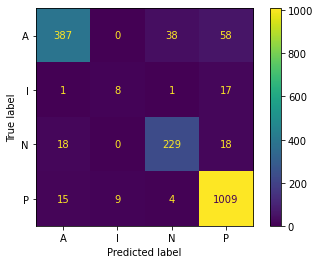

In [245]:
ConfusionMatrixDisplay.from_estimator(gbc, X_features_test, y_test)  

### CatBoost

In [259]:
cbc = CatBoostClassifier(
    random_seed=42,
    logging_level='Silent',
    early_stopping_rounds=15
)

cbc.fit(
    X_features, y_train,
    eval_set=(X_features_test, y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [260]:
y_pred = cbc.predict(X_features_test)

In [261]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.93      0.77      0.84       483
           I       0.50      0.11      0.18        27
           N       0.82      0.85      0.83       265
           P       0.90      0.98      0.94      1037

    accuracy                           0.89      1812
   macro avg       0.79      0.68      0.70      1812
weighted avg       0.89      0.89      0.89      1812



In [262]:
print(f"Test Balanced Accuracy for the dataset is about: {balanced_accuracy_score(y_test, y_pred):.2f}")

Test Balanced Accuracy for the dataset is about: 0.68


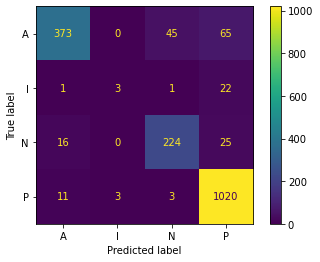

In [263]:
ConfusionMatrixDisplay.from_estimator(cbc, X_features_test, y_test)  

### XgBoost

In [267]:
xgbc = XGBClassifier(use_label_encoder=True, eval_metric='mlogloss')
xgbc.fit(X_features, y_train)

c:\Users\doxda\anaconda3\envs\py39IIM\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [268]:
y_pred = xgbc.predict(X_features_test)

In [269]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.93      0.80      0.86       483
           I       0.50      0.11      0.18        27
           N       0.85      0.88      0.87       265
           P       0.91      0.98      0.95      1037

    accuracy                           0.91      1812
   macro avg       0.80      0.69      0.71      1812
weighted avg       0.90      0.91      0.90      1812



In [270]:
print(f"Test Balanced Accuracy for the dataset is about: {balanced_accuracy_score(y_test, y_pred):.2f}")

Test Balanced Accuracy for the dataset is about: 0.69


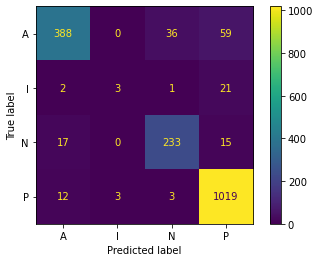

In [271]:
ConfusionMatrixDisplay.from_estimator(xgbc, X_features_test, y_test)  

# 5. Exercicio 5